In [1]:
import warnings # Librería para ignorar warnings
warnings.filterwarnings('ignore')  # Ignorar todos los warnings
import pandas as pd # Librería para análisis de datos
pd.set_option('future.no_silent_downcasting', True)  # Opción para evitar el warning específico en jupyter notebook
import sys # Librería para manejo de archivos
import os # Librería para manejo de archivos

# Añade la ruta del directorio principal del proyecto
sys.path.append(os.path.abspath(".."))  # Subir un nivel desde vanguard-ab-test-team-14

# Función para instalar los requisitos
from scripts.install_requirements import install_requirements

# Llamar a la función para instalar los requisitos
install_requirements()

# Función para la limpieza y manipulación de datos
from scripts.functions import *

Iniciando la instalación de paquetes...
Instalando el paquete: pandas==2.2.2
Instalación exitosa: pandas==2.2.2
Instalando el paquete: numpy==1.26.4
Instalación exitosa: numpy==1.26.4
Instalando el paquete: scipy==1.14.1
Instalación exitosa: scipy==1.14.1
Instalando el paquete: statsmodels==0.14.3
Instalación exitosa: statsmodels==0.14.3
Instalando el paquete: matplotlib==3.9.2
Instalación exitosa: matplotlib==3.9.2
Instalando el paquete: seaborn==0.13.2
Instalación exitosa: seaborn==0.13.2
Instalando el paquete: jupyterlab==4.2.5
Instalación exitosa: jupyterlab==4.2.5
Todos los paquetes han sido instalados exitosamente.


# 0. Importar data sets

In [2]:
# Define the path relativo a tu notebook
data_folder = os.path.join("..", "data", "raw")

# Lee los archivos CSV desde la carpeta data/raw
df_final_demo = pd.read_csv(os.path.join(data_folder, "df_final_demo.txt"))
df_final_experiment_clients = pd.read_csv(os.path.join(data_folder, "df_final_experiment_clients.txt"))
df_final_web_data_pt_1 = pd.read_csv(os.path.join(data_folder, "df_final_web_data_pt_1.txt"))
df_final_web_data_pt_2 = pd.read_csv(os.path.join(data_folder, "df_final_web_data_pt_2.txt"))


## 1.Exploración de datos

In [3]:
# Revisar los tipos de datos
df_final_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   clnt_tenure_yr    70595 non-null  float64
 2   clnt_tenure_mnth  70595 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70595 non-null  object 
 5   num_accts         70595 non-null  float64
 6   bal               70595 non-null  float64
 7   calls_6_mnth      70595 non-null  float64
 8   logons_6_mnth     70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB


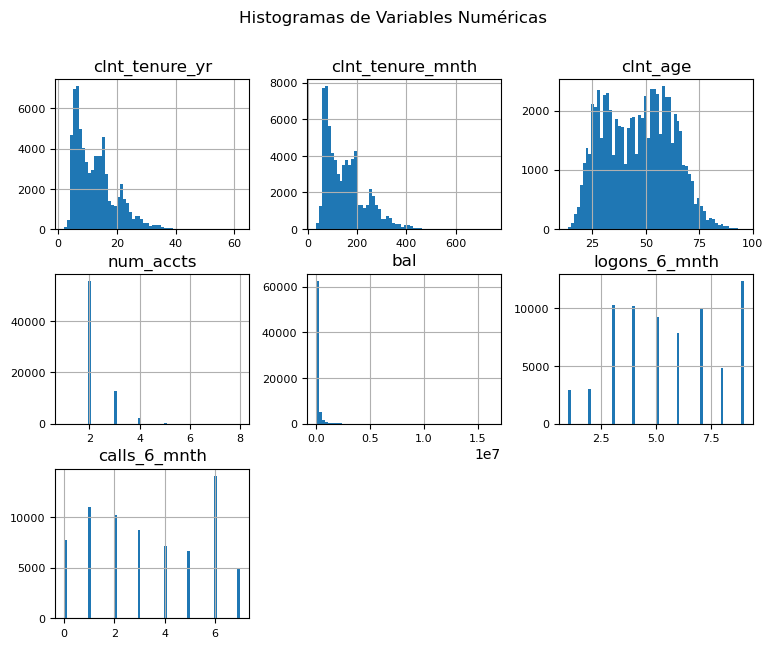

In [4]:
# Revisar los tipos de datos
df_demo_numeric = df_final_demo[["clnt_tenure_yr", "clnt_tenure_mnth", "clnt_age", "num_accts", "bal", "logons_6_mnth", "calls_6_mnth"]]

plot_histograms(df_demo_numeric) # Generar histogramas


1. **clnt_tenure_yr** y **clnt_tenure_mnth**: La mayoría de los clientes tiene menos de 20 años de permanencia (240 meses), con algunos casos aislados que superan los 40 años.
2. **clnt_age**: La edad de los clientes está distribuida principalmente entre 25 y 75 años.
3. **num_accts**: La mayoría de los clientes tiene entre 1 y 2 cuentas.
4. **bal**: La mayoría de los saldos están concentrados en montos bajos, con algunos valores extremadamente altos.
5. **logons_6_mnth**: Las frecuencias de inicio de sesión se distribuyen uniformemente hasta 8 veces en los últimos 6 meses.
6. **calls_6_mnth**: El número de llamadas en los últimos 6 meses también sigue una distribución similar, con picos regulares.

En resumen, se observa una concentración de clientes en los rangos bajos de saldo y cuentas, con una distribución más amplia en la edad y el tiempo de permanencia.


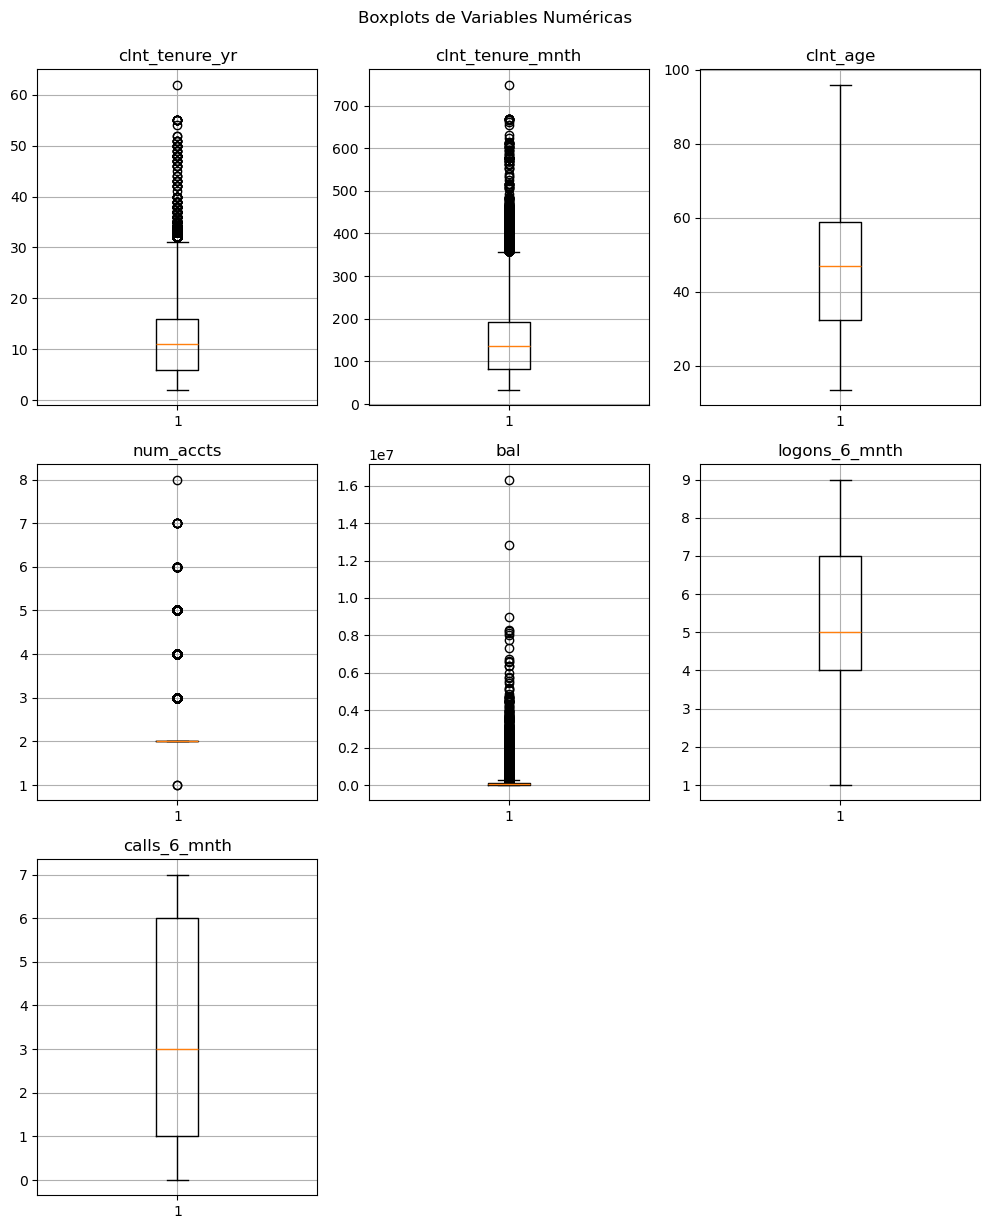

In [5]:
# Revisar los tipos de datos
plot_boxplots(df_demo_numeric)

1. **clnt_tenure_yr** y **clnt_tenure_mnth**: Ambas distribuciones tienen una alta concentración de clientes con menos de 20 años o 240 meses de antigüedad, mostrando muchos valores atípicos (outliers) hacia los extremos superiores.
2. **clnt_age**: La distribución de la edad se centra entre los 30 y 60 años, con pocos clientes menores de 30 o mayores de 80.
3. **num_accts**: La mayoría de los clientes tiene entre 1 y 2 cuentas, con algunos casos aislados que tienen hasta 8 cuentas.
4. **bal**: Hay una alta concentración de balances bajos, con varios valores atípicos que superan los 10 millones.
5. **logons_6_mnth**: Las frecuencias de inicio de sesión en 6 meses varían entre 1 y 9, sin outliers claros.
6. **calls_6_mnth**: Las llamadas en los últimos 6 meses se distribuyen entre 1 y 6, sin valores atípicos.

Este análisis revela distribuciones bastante asimétricas en algunas variables, como el balance, y un número considerable de outliers en la antigüedad y número de cuentas.


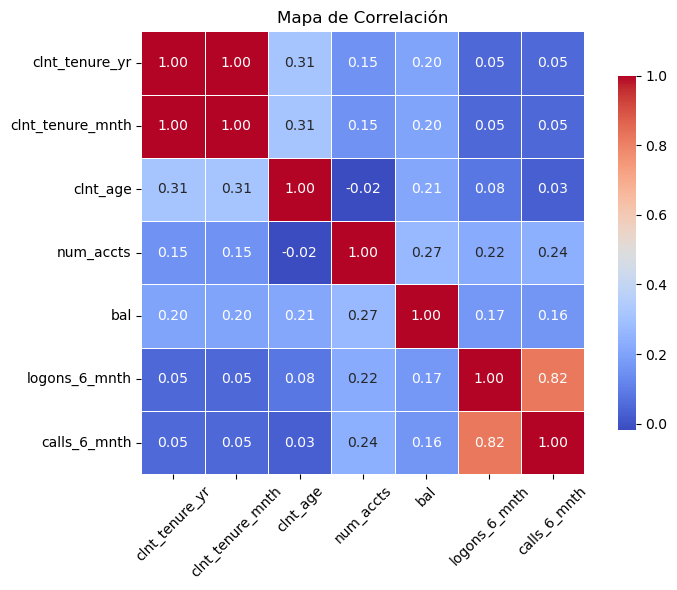

In [6]:
plot_correlation_matrix(df_demo_numeric)  # Generar mapa de correlación

- Las variables de permanencia en años y meses tienen una correlación igual a uno pues representan lo mismo.
- Se observa tambien alta correlación entre las variables logons_6_mnth y call_6_mnth

# 2. Limpieza y union de data sets 

### Resumen de Principales Actos de Limpieza de Datos en el EDA

1. **Limpieza de Inconsistencias**:
   - **Usuarios menores de 18 años**: Se eliminaron del análisis aquellos registros de clientes que tenían menos de 18 años, ya que no correspondían con el perfil de usuarios válidos para el estudio.
   - **Clientes con permanencia mayor que su edad**: Se identificaron y eliminaron los registros de clientes cuyo tiempo de permanencia en la compañía era mayor que su edad, ya que representaban errores evidentes en los datos.

2. **Limpieza de Outliers**:
   - **Variable `bal` (Balance)**: Se observó una alta variabilidad en los balances con valores extremos significativos. Para reducir la varianza y mitigar el impacto de los outliers, los datos fueron recategorizados en tres grupos: **bajo**, **medio** y **alto**, permitiendo un análisis más manejable y centrado en rangos relevantes para el negocio.

3. **Eliminación de Variables Redundantes**:
   - **Tiempo de permanencia en meses**: Se eliminó la variable `clnt_tenure_mnth` (tiempo de permanencia en meses) debido a que proporcionaba la misma información que `clnt_tenure_yr` (tiempo de permanencia en años), pero a una escala diferente, lo que no aportaba valor adicional al análisis.   

Este proceso de limpieza aseguró una mayor consistencia y precisión en los datos, mejorando la calidad del análisis posterior.


In [7]:
# Limpiar los datos
df_demo_clean = clean_demo_data(df_final_demo)
df_experiment_clean = clean_experiment_clients_data(df_final_experiment_clients)
df_web_clean = clean_web_data(df_final_web_data_pt_1, df_final_web_data_pt_2)

# Unir los datasets limpios
df_final = merge_datasets(df_web_clean, df_experiment_clean, df_demo_clean)

In [8]:
# Revisar los tipos de datos
df_final.head(3)

,client_id,visitor_id,visit_id,process_step,date_time,is_complete,time_before_step,time_diff_step,prev_process_step,is_error,Variation,clnt_tenure_yr,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,bal_category,account_since_child
0,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,1,NaT,NaN,NaN,False,Test,3,29,U,2,25454.66,2,6,bajo,no
1,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,1,2017-04-15 12:57:56,7.0,start,False,Test,3,29,U,2,25454.66,2,6,bajo,no
2,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,1,2017-04-15 12:58:03,32.0,step_1,False,Test,3,29,U,2,25454.66,2,6,bajo,no


In [9]:
# Revisar los tipos de datos
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318614 entries, 0 to 318613
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_id            318614 non-null  int64         
 1   visitor_id           318614 non-null  object        
 2   visit_id             318614 non-null  object        
 3   process_step         318614 non-null  category      
 4   date_time            318614 non-null  datetime64[ns]
 5   is_complete          318614 non-null  object        
 6   time_before_step     249751 non-null  datetime64[ns]
 7   time_diff_step       249751 non-null  float64       
 8   prev_process_step    249751 non-null  category      
 9   is_error             318614 non-null  bool          
 10  Variation            318614 non-null  object        
 11  clnt_tenure_yr       318614 non-null  int32         
 12  clnt_age             318614 non-null  int32         
 13  gendr         

In [10]:
# Guardar los datos limpios
clean_folder = os.path.join("..", "data", "clean")
df_final.to_csv(os.path.join(clean_folder, "df_final.csv"), index=False)

# 3. KPIs

## 3.1 Tasa de finalización

In [11]:
# Revisar los tipos de datos
completion_stats = calculate_completion_stats(df_final)
completion_stats

,Variation,Completed Clients,Incomplete Clients,Completion Rate (%),Incompletion Rate (%)
0,general,33782,16279,67.481672,32.518328
1,Control,15286,8052,65.498329,34.501671
2,Test,18496,8227,69.213786,30.786214


## 3.2 Tiempo en cada paso

In [12]:
# Revisar los tipos de datos
time_stats = calculate_time_stats(df_final)
time_stats

,Variation,process_step,mean_time,min_time,max_time,num_entries
0,Control,start,151.886076,0.0,40235.0,16590
1,Control,step_1,43.037307,0.0,4150.0,29137
2,Control,step_2,38.770338,0.0,1724.0,25555
3,Control,step_3,92.975700,0.0,3635.0,22428
4,Control,confirm,129.046178,0.0,9396.0,16588
5,Test,start,147.305936,0.0,24819.0,23263
6,Test,step_1,37.667716,0.0,3636.0,38115
7,Test,step_2,48.276693,0.0,1858.0,30561
8,Test,step_3,96.897236,0.0,1923.0,25398
9,Test,confirm,129.194520,0.0,14581.0,22116


## 3.3 Tasa de errores

In [13]:
# Revisar los tipos de datos
error_rate_stats = calculate_error_rate(df_final)
error_rate_stats

,Group,Total Records,Total Errors,Error Rate (%)
0,Control,142286,9545,6.71
1,Test,176328,16138,9.15


# 4. Prueba de hipotesis

**1.4 Hipótesis de tasa de finalización**
Dado que el nuevo diseño (grupo de prueba) tuvo una tasa de finalización más alta en comparación con el diseño anterior (grupo de control), debe confirmar si esta diferencia es estadísticamente significativa.

**H0: La media de tasa de finalización entre grupos es igual**

**H1: La media de tasa de finalización entre grupos es diferente**

In [14]:
# Revisar los tipos de datos
hypothesis_testing_completion(df_final, alpha=0.05)

{'z_statistic': 8.852784239404492,
 'p_value': 4.268129320634861e-19,
 'decision': 'Rechaza la hipótesis nula: hay una diferencia significativa en las tasas de finalización.'}

**2.4 Hipótesis umbral costo - efectividad**

Umbral : Vanguard ha establecido este aumento mínimo en la tasa de finalización en un 5 % . Se estima que esta es la tasa a la que los beneficios proyectados, en términos de mayor participación de los usuarios y posibles ingresos, superarán los costos del nuevo diseño.

Se le solicita que realice otro análisis para asegurarse de que el aumento observado en la tasa de finalización de la prueba A/B cumpla o supere este umbral del 5 % . Si el nuevo diseño no genera al menos este nivel de mejora, es posible que no se justifique desde una perspectiva de costos, independientemente de su importancia estadística.

**H0: El aumento de la tasa de finalización no alcanza el umbral del 5%**

**H1: El aumento en la tasa de finalización es significativo y cumple el umbral del 5%**

In [15]:
# Revisar los tipos de datos
hypothesis_testing_with_threshold(df_final, cost_effectiveness_threshold=0.05, alpha=0.05)

{'z_statistic': -159.12291829092155,
 'p_value': 1.0,
 'decision': 'No se rechaza la hipótesis nula: el aumento en la tasa de completación no cumple con el umbral del 5%.'}

**3.4 Hipotesis diferencias de tiempos por pasos**

Se realiza una prueba de hipótesis para comparar las medias de duración por paso entre los grupos Control y Test

**H0: La media de duracion por pasos entre los grupos son iguales**

**H1: La media de duracion por pasos entre los grupos son diferentes**

In [16]:
# Revisar los tipos de datos
hypothesis_test_time_stats(df_final, alpha=0.05)

,process_step,Control Mean Time,Test Mean Time,T-Statistic,P-Value,Alpha,Decision
0,start,151.89,147.31,1.0066,0.3142,0.05,No se rechaza H₀
1,step_1,43.04,37.67,6.9414,0.0000,0.05,Se rechaza H₀
2,step_2,38.77,48.28,-13.4010,0.0000,0.05,Se rechaza H₀
3,step_3,92.98,96.90,-3.5658,0.0004,0.05,Se rechaza H₀
4,confirm,129.05,129.19,-0.0668,0.9467,0.05,No se rechaza H₀


Interpretación

- **Inicio (start)**: No hay diferencia significativa en los tiempos promedio entre el grupo de Control y el Test (p-valor = 0.3142).
- **Paso 1 (step_1)**: Existe una diferencia significativa, con el grupo Test siendo más rápido que el Control (p-valor = 0.0000).
- **Paso 2 (step_2)**: El grupo Test es significativamente más lento que el Control (p-valor = 0.0000).
- **Paso 3 (step_3)**: El grupo Test es ligeramente más lento que el Control, con una diferencia significativa (p-valor = 0.0004).
- **Confirmación (confirm)**: No hay diferencia significativa entre ambos grupos (p-valor = 0.9467).

**Decisión general**: Se rechaza la hipótesis nula (H₀) en los pasos 1, 2 y 3, indicando diferencias significativas. En el inicio y confirmación, no se rechaza H₀.


**3.5 Hipotesis diferencias en tasas de error**

Se realiza una prueba de hipótesis para comparar las tasas de error entre los grupos Control y Test

**H0: La tasa de error entre los grupos son iguales**

**H1: La tasa entre los grupos son diferentes**

In [17]:
# Revisar los tipos de datos
hypothesis_test_error_rate(df_final, alpha=0.05)

{'Control Error Rate (%)': 6.71,
 'Test Error Rate (%)': 9.15,
 'Z-Statistic': -25.1918,
 'P-Value': 0.0,
 'Alpha': 0.05,
 'Decision': 'Se rechaza H₀',
 'Explanation': 'Las diferencias en las tasas de error son estadísticamente significativas'}

**3.6 Hipotesis Edad por grupos**

Evaluar si ha existido diferencia entre las edades por grupo 

**H0 : No hubo diferencia entre las edades de los grupos**

**H1 : Si hubo diferencia entre las edades de los grupos**

In [18]:
# Definición de la tabla de dimensiones de cliente
df_test = df_final[df_final['Variation'] == 'Test']
df_control = df_final[df_final['Variation'] == 'Control']
hypothesis_testing(df_test, df_control, "clnt_age", alpha=0.05)

{'t_statistic': -0.3368883107328185,
 'p_value': 0.7362364795738359,
 'decision': 'No se rechaza la hipótesis nula: no hay una diferencia significativa entre los grupos.'}

**3.7 Hipotesis Tiempo de permanencia por grupos**

Evaluar si ha existido diferencia entre las edades por grupo 

**H0 : No hubo diferencia entre el tiempo de permanencia de los grupos**

**H1 : Si hubo diferencia entre el tiempo de permanencia de los grupos**

In [19]:
# Definición de la tabla de dimensiones de cliente
hypothesis_testing(df_test, df_control, "clnt_tenure_yr", alpha=0.05)

{'t_statistic': -0.3754411672192049,
 'p_value': 0.7073722458536125,
 'decision': 'No se rechaza la hipótesis nula: no hay una diferencia significativa entre los grupos.'}

# 5. Creación de tablas de dimensiones y de hecho

La tabla `df_final` se reestructura en tablas de dimensión y de hecho, siguiendo el esquema estrella o snowflake, para facilitar su evaluación en Tableau. Esta división permite:

1. **Mejora en el rendimiento**: Al separar las dimensiones (como usuarios, fechas, productos) de los hechos (transacciones, tiempos, errores), se reduce la redundancia de datos y mejora el tiempo de respuesta en las consultas.
   
2. **Mayor flexibilidad en el análisis**: Las dimensiones proporcionan contexto y permiten desglosar y filtrar los hechos a través de jerarquías como edad, género, o periodo de tiempo, facilitando el análisis granular.
   
3. **Simplificación de reportes**: La separación en tablas de dimensiones y hechos permite la creación de cálculos más eficientes en Tableau y genera visualizaciones más claras.

**dim_client, dim_visitor, dim_visit, fact_process**

In [20]:
# Definición de la tabla de dimensiones de cliente
dim_client = df_final[['client_id', 'clnt_tenure_yr', 'clnt_age', 'gendr', 
                       'num_accts', 'bal', 'calls_6_mnth', 
                       'logons_6_mnth', 'bal_category', 
                       'account_since_child']].drop_duplicates()

# Definición de la tabla de dimensiones de visitante
dim_visitor = df_final[['visitor_id', 'client_id']].drop_duplicates()

# Definición de la tabla de dimensiones de visitas
dim_visit = df_final[['visit_id', 'visitor_id', 'date_time']].drop_duplicates()

# Definición de la tabla de hechos del proceso digital
fact_process = df_final[['visit_id', 'process_step', 'date_time', 
                         'is_complete', 'time_before_step', 
                         'time_diff_step', 'prev_process_step', 
                         'is_error', 'Variation']]



In [21]:
# Define la ruta relativa hacia la carpeta "tableau"
tableau_folder = os.path.join("..", "data", "tableau")

# Guarda los archivos CSV en la carpeta "tableau" para usarlos en los dashboards
dim_client.to_csv(os.path.join(tableau_folder, "dim_client.csv"), index=False)
dim_visitor.to_csv(os.path.join(tableau_folder, "dim_visitor.csv"), index=False)
dim_visit.to_csv(os.path.join(tableau_folder, "dim_visit.csv"), index=False)
fact_process.to_csv(os.path.join(tableau_folder, "fact_process.csv"), index=False)
